In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import collections
import datasets
import einops
import string
import json
import tqdm
import glob
import re

# Visual Genome Dataset

In [2]:
project_path = "C:/Users/Natha/Artificial Intelligence/Tensorflow Image Recognition/VisualQuestionAnswering"

In [3]:
image_paths = glob.glob(f"{project_path}/images/VG_100K/*")
image_paths_sorted = []
questions = []
answers = []

with open(f"{project_path}/question_answers.json", "r") as f:
    data = json.load(f)
    i = 0
    for element in data:
        if element['qas'] != []:
            for question in element['qas']:
                questions.append(question['question'])
                answers.append(question['answer'])
                image_paths_sorted.append(f"{project_path}/images/VG_100K/{element['id']}.jpg")
            i+= 1

In [4]:
len(answers)

1445322

In [5]:
train_image_paths, train_questions, train_answers = image_paths_sorted[:1_200_000], questions[:1_200_000], answers[:1_200_000]
val_image_paths, val_questions, val_answers = image_paths_sorted[1_200_000:], questions[1_200_000:], answers[1_200_000:]

In [6]:
train_raw = (
    tf.data.Dataset
    .from_tensor_slices(((train_image_paths, train_questions), train_answers))
)
val_raw = (
    tf.data.Dataset
    .from_tensor_slices(((val_image_paths,val_questions), val_answers))
)

# Process Dataset

In [7]:
IMAGE_SHAPE = (224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(input_shape=IMAGE_SHAPE, include_top=False)
mobilenet.trainable = False

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [9]:
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    s = tf.strings.join(["[START]", s, '[END]'], separator=' ')
    return s

In [10]:
vocabulary_size = 25000
answer_tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size,
                                                  standardize=standardize,
                                                  ragged=True)
question_tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size,
                                                  standardize=standardize,
                                                  output_sequence_length=49)

In [11]:
answer_tokenizer.adapt(answers)
question_tokenizer.adapt(questions)

In [12]:
question_tokenizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'the', 'is', 'what', 'are', 'where', 'on']

In [13]:
answer_tokenizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'the', 'a', 'on', 'white', 'in', 'and']

In [14]:
t = answer_tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[2, 5, 65, 8, 5, 89, 3], [2, 5, 4529, 56, 3]]>

In [15]:
word_to_index = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary=answer_tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary=answer_tokenizer.get_vocabulary(),
                                             invert=True)

In [16]:
# Copy the image over for each description in the data
def match_shapes(input, answers):
    (images, questions) = input
    answers_shape = einops.parse_shape(answers, 'b c')
    answers = einops.rearrange(answers, 'b c -> (b c)')
    images = einops.repeat(images, 'b ... ->  (b c) ...', c=answers_shape['c'])
    questions = einops.repeat(questions, 'b ... -> (b c) ...', c=answers_shape['c'])
    return (images, questions), answers

In [17]:
for (ex_paths, ex_questions), ex_answers in train_raw.batch(32).take(1):
    break

print('image paths:', ex_paths.shape)
print('questiop paths: ', ex_questions.shape)
print('answers:', ex_answers.shape)

print()
print('example image path: ', ex_paths[0])
print('example question: ', ex_questions[0])
print('example answer: ', ex_answers[0])

image paths: (32,)
questiop paths:  (32,)
answers: (32,)

example image path:  tf.Tensor(b'C:/Users/Natha/Artificial Intelligence/Tensorflow Image Recognition/VisualQuestionAnswering/images/VG_100K/1.jpg', shape=(), dtype=string)
example question:  tf.Tensor(b'What color is the clock?', shape=(), dtype=string)
example answer:  tf.Tensor(b'Green.', shape=(), dtype=string)


In [18]:
def prepare_txt(input, txts):
    (images, questions) = input
    answer_tokens = answer_tokenizer(txts)
    question_tokens = question_tokenizer(questions)
    
    input_tokens = answer_tokens[..., :-1]
    label_tokens = answer_tokens[..., 1:]
    return (images, question_tokens, input_tokens), label_tokens

In [19]:
def prepare_dataset(ds, batch_size=32, shuffle_buffer=1000):
    def process_data(input, answer):
        (image, question) = input
        image = load_image(image)
        return (image, question), answer
    
    ds = (ds
          .shuffle(1_500_000)
          .map(process_data)
          .apply(tf.data.experimental.ignore_errors())
          .batch(batch_size))
    
    def to_tensor(inputs, labels):
        (images, question, in_tok), out_tok = inputs, labels
        return (images, question, in_tok.to_tensor()), out_tok.to_tensor()
    
    return (ds
#             .map(match_shapes, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(shuffle_buffer)
            .batch(batch_size)
            .map(prepare_txt, tf.data.AUTOTUNE)
            .map(to_tensor, tf.data.AUTOTUNE))

In [20]:
train_ds = prepare_dataset(train_raw, batch_size=256)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 49), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [21]:
val_ds = prepare_dataset(val_raw, batch_size=256)
val_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 49), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [22]:
question_word_to_index = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary=question_tokenizer.get_vocabulary())
question_index_to_word = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary=question_tokenizer.get_vocabulary(),
                                             invert=True)

In [23]:
for (image, question, context_in), context_out in train_ds.take(1):
    print(question_index_to_word(question[0]))
    print(index_to_word(context_in[0]))
    print(index_to_word(context_out[0]))

tf.Tensor(
[b'[START]' b'what' b'gender' b'is' b'the' b'person' b'in' b'the'
 b'purple' b'shirt' b'[END]' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b''], shape=(49,), dtype=string)
tf.Tensor([b'[START]' b'female' b'' b'' b'' b'' b'' b''], shape=(8,), dtype=string)
tf.Tensor([b'female' b'[END]' b'' b'' b'' b'' b'' b''], shape=(8,), dtype=string)


# Create model 

### Input embedding

In [24]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()
        
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
        
        self.token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=depth, mask_zero=True)
        
        self.add = tf.keras.layers.Add()
        
    def call(self, seq):
        seq = self.token_embedding(seq)
        
        x = tf.range(tf.shape(seq)[1])
        x = x[tf.newaxis, :]
        x = self.pos_embedding(x)
        
        return self.add([seq, x])

### Decoder

In [25]:
class CausalAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        attn = self.mha(query=x, value=x, use_causal_mask=True)
        x = self.add([x, attn])
        return self.layernorm(x)

In [26]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
        
    def call(self, x, y, **kwargs):
        attn, attention_scores = self.mha(query=x, value=y, return_attention_scores=True)
        
        self.last_attention_scores = attention_scores
        
        x = self.add([x, attn])
        return self.layernorm(x)

In [27]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),
            tf.keras.layers.Dense(units=units),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ])

        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = x + self.seq(x)
        return self.layernorm(x)

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout_rate=0.1):
        super().__init__()
        self.self_attention = CausalAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
        self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
        self.merge = tf.keras.layers.Concatenate(axis=-1)
        
    def call(self, inputs, training=False):
        in_seq_i, in_seq_q, out_seq = inputs
        
        in_seq = self.merge([in_seq_i, in_seq_q])
        
        out_seq = self.self_attention(out_seq)
        out_seq = self.cross_attention(out_seq, in_seq)
        
        self.last_attention_scores = self.cross_attention.last_attention_scores
        
        out_seq = self.ff(out_seq)
        return out_seq

In [29]:
class TokenOutput(tf.keras.layers.Layer):
    def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
        super().__init__()

        self.dense = tf.keras.layers.Dense(
            units=tokenizer.vocabulary_size(), **kwargs)
        self.tokenizer = tokenizer
        self.banned_tokens = banned_tokens

        self.bias = None

    def adapt(self, ds):
        counts = collections.Counter()
        vocab_dict = {name: id 
                      for id, name in enumerate(self.tokenizer.get_vocabulary())}

        for tokens in tqdm.tqdm(ds):
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
        counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

        counts_arr = counts_arr[:]
        for token in self.banned_tokens:
            counts_arr[vocab_dict[token]] = 0

        total = counts_arr.sum()
        p = counts_arr/total
        p[counts_arr==0] = 1.0
        log_p = np.log(p)  # log(1) == 0

        entropy = -(log_p*p).sum()

        print()
        print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
        print(f"Marginal entropy: {entropy:0.2f}")

        self.bias = log_p
        self.bias[counts_arr==0] = -1e9

    def call(self, x):
        x = self.dense(x)
        # TODO(b/250038731): Fix this.
        # An Add layer doesn't work because of the different shapes.
        # This clears the mask, that's okay because it prevents keras from rescaling
        # the losses.
        return x + self.bias

In [30]:
output_layer = TokenOutput(answer_tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

4688it [10:04,  7.75it/s]


Uniform entropy: 10.12
Marginal entropy: 4.62


### Build Model

In [31]:
class Responder(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    
    def __init__(self, answer_tokenizer, question_tokenizer, feature_extractor, output_layer, num_layers=1,
                 units=256, max_length=50, num_heads=1, dropout_rate=0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        #self.tokenizer = tokenizer
        self.word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=answer_tokenizer.get_vocabulary())
        self.index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=answer_tokenizer.get_vocabulary(), invert=True)
        
        self.ans_seq_embedding = SeqEmbedding(vocab_size=answer_tokenizer.vocabulary_size(), 
                                          depth=units,
                                          max_length=max_length)
        self.qes_seq_embedding = SeqEmbedding(vocab_size=question_tokenizer.vocabulary_size(),
                                             depth=units,
                                             max_length=49)
        self.decoder_layers = [DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate) for n in range(num_layers)]
        
        self.output_layer = output_layer

In [32]:
@Responder.add_method
def call(self, inputs):
    image, question, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')
    
    if question.dtype == tf.string:
        question = tf.expand_dims(question_tokenizer(question), axis=0)

    if txt.dtype == tf.string:
        # Apply the tokenizer if you get string inputs.
        txt = answer_tokenizer(txt)
        
    txt = self.ans_seq_embedding(txt)
    
    question = self.qes_seq_embedding(question)

    # Look at the image
    for dec_layer in self.decoder_layers:
        txt = dec_layer(inputs=(image, question, txt))

    txt = self.output_layer(txt)

    return txt

In [33]:
model = Responder(answer_tokenizer, question_tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.1, num_layers=3, num_heads=5)

In [34]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

In [35]:
@Responder.add_method
def simple_gen(self, image, question, temperature=1):
    initial = self.word_to_index([['[START]']]) # (batch, sequence)
    img_features = self.feature_extractor(image[tf.newaxis, ...])

    tokens = initial # (batch, sequence)
    for n in range(50):
        preds = self((img_features, question, tokens)).numpy()  # (batch, sequence, vocab)
        preds = preds[:,-1, :]  #(batch, vocab)
        if temperature==0:
            next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
        else:
            next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
        tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

        if next[0] == self.word_to_index('[END]'):
            break
            
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()

In [36]:
for t in (0.0, 0.5, 1.0):
    result = model.simple_gen(image, tf.convert_to_tensor("How many people are in the image?"), temperature=t)
    print(result)



a in red


In [37]:
def masked_loss(labels, preds):  
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

    mask = (labels != 0) & (loss < 1e8) 
    mask = tf.cast(mask, loss.dtype)

    loss = loss*mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_acc(labels, preds):
    mask = tf.cast(labels!=0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
    return acc

In [38]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self):
        image_url = 'https://tensorflow.org/images/surf.jpg'
        image_path1 = tf.keras.utils.get_file('surf.jpg', origin=image_url)
        image_path2 = f"{project_path}/dog_image.jpg"
        self.image1 = load_image(image_path1)
        self.image2 = load_image(image_path2)

    def on_epoch_end(self, epochs=None, logs=None):
        print()
        print()
        for t in (0.0, 0.5, 1.0):
            print(self.model.simple_gen(self.image1, tf.convert_to_tensor("what color is the mans shirt?"), temperature=t))
            print(self.model.simple_gen(self.image1, tf.convert_to_tensor("Where was the photo taken?"), temperature=t))
            print(self.model.simple_gen(self.image2, tf.convert_to_tensor("How many dogs are in the image?"), temperature=t))
            print(self.model.simple_gen(self.image2, tf.convert_to_tensor("What are the dogs doing?"), temperature=t))
            print()
        print()

In [39]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=.1, patience=10, min_delta=0.001)]

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [41]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=200,
    validation_data=val_ds.repeat(),
    validation_steps=50,
    epochs=50,
    callbacks=callbacks)

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 3.8304 - masked_acc: 0.4333

white
on the ground
one
to the water

red
in the daytime
1
to the left

black
in the outside
one
airplane


200/200 [==============================] - 53s 235ms/step - loss: 3.8304 - masked_acc: 0.4333 - val_loss: 2.8826 - val_masked_acc: 0.5148 - lr: 3.0000e-04
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 3.2463 - masked_acc: 0.4847

white
in the water
one
playing

white
in a water
1
surfing

white
on the beach
one
sitting


200/200 [==============================] - 42s 210ms/step - loss: 3.2463 - masked_acc: 0.4847 - val_loss: 2.5385 - val_masked_acc: 0.5389 - lr: 3.0000e-04
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 2.9935 - masked_acc: 0.5033

blue
in the ocean
one
eating

orange
in a zoo
one
playing a tennis

black
in the ocean
three
in the sand


200/200 [==============================] - 42s 211ms/step - loss: 2.9935 - masked_acc

Epoch 24/50
200/200 [==============================] - ETA: 0s - loss: 2.1717 - masked_acc: 0.5724

blue
in the ocean
one
playing frisbee

blue
in the ocean
1
grazing

gray
on a beach
one
playing in a tropical area


200/200 [==============================] - 45s 226ms/step - loss: 2.1717 - masked_acc: 0.5724 - val_loss: 1.8178 - val_masked_acc: 0.6093 - lr: 3.0000e-04
Epoch 25/50
200/200 [==============================] - ETA: 0s - loss: 2.1270 - masked_acc: 0.5754

blue
in the ocean
one
playing

black
in the ocean
one
playing

white
at a beach
zero
playing frisbee


200/200 [==============================] - 43s 214ms/step - loss: 2.1270 - masked_acc: 0.5754 - val_loss: 1.8186 - val_masked_acc: 0.6114 - lr: 3.0000e-04
Epoch 26/50
200/200 [==============================] - ETA: 0s - loss: 2.1206 - masked_acc: 0.5728

white
in the ocean
one
playing

red
ocean
two
standing

black
on an ocean
2
sitting


200/200 [==============================] - 43s 214ms/step - loss: 2.1206 - masked_ac

# Inference

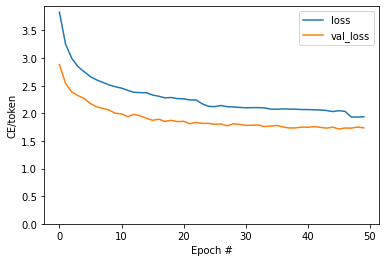

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

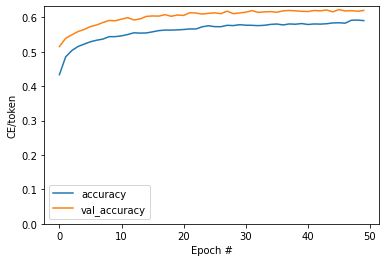

In [43]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Implement

'to graze'

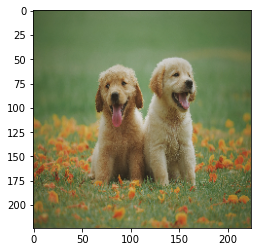

In [79]:
file_path = "C:/Users/Natha/Artificial Intelligence/Tensorflow Image Recognition/VisualQuestionAnswering/dog_image.jpg"
image = load_image(file_path)

plt.imshow(image/255)

result = model.simple_gen(image, 
                          tf.convert_to_tensor("Why are the dogs in a field?"), 
                          temperature=0.5)
result